In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import StratifiedKFold

# pre-processing
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string 
from pprint import pprint
from gensim.corpora import Dictionary

# genism models
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense
from gensim.models import Word2Vec

#metrics
from sklearn.metrics import accuracy_score

In [2]:
#reading data
df=pd.read_csv('all-data.csv',encoding='latin-1',names=['Sentiment','Text'])
df.head()

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
#data cleaning
#checking for null values and removing if any
print(df.isnull().sum())

Sentiment    0
Text         0
dtype: int64


<AxesSubplot:ylabel='Sentiment'>

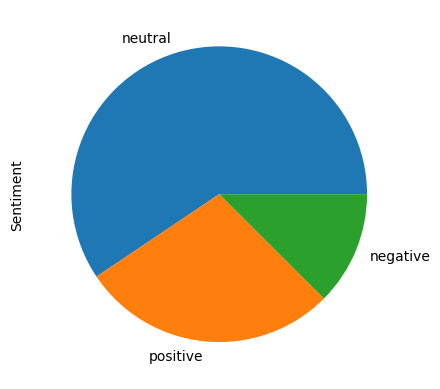

In [4]:
#EDA
df['Sentiment'].value_counts().plot(kind='pie')

In [5]:
df['Sentiment'].value_counts()

neutral     2879
positive    1363
negative     604
Name: Sentiment, dtype: int64

In [6]:
def pre_processing(docs):
    tokenizer = RegexpTokenizer(r"\w+(?:[-'+]\w+)*|\w+")
    en_stop = get_stop_words('en')
    for doc in docs:
        raw_text = doc.lower()
        # tokenization
        tokens_text = tokenizer.tokenize(raw_text)
        # remove stopwords
        stopped_tokens_text = [i for i in tokens_text if not i in en_stop]
        # remoce digis and one-charcter word        
        doc = [token for token in stopped_tokens_text if not token.isnumeric()]
        doc = [token for token in doc if len(token) > 1]
        yield doc

In [7]:
X = df['Text']
y = df['Sentiment']

# Create a LabelEncoder object
le = LabelEncoder()
# Fit and transform the data in y using LabelEncoder
y = le.fit_transform(y)
# Print the encoded values
# get the unique values and their counts
unique, counts = np.unique(y, return_counts=True)

# print the results
for val, count in zip(unique, counts):
    print(val, count)

0 604
1 2879
2 1363


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99,shuffle=True)
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

3876 3876
970 970


In [9]:
doc_tokens = list(pre_processing(X_train))
vocab = Dictionary.from_documents(doc_tokens)
print(len(vocab))
test_tokens=list(pre_processing(X_test))

8743


## Visualization using tfidf

In [10]:
doc_bows = [vocab.doc2bow(doc) for doc in doc_tokens]
tfidf = TfidfModel(doc_bows)
X_train = corpus2dense(tfidf[doc_bows], num_terms=len(vocab), num_docs=len(doc_bows))
X_train = X_train.transpose()

3876


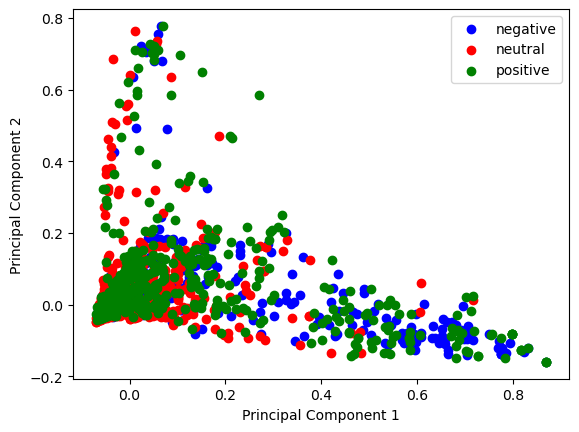

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
print(len(X_pca))

plt.scatter(X_pca[y_train==0, 0], X_pca[y_train==0, 1], color='blue', label='negative')
plt.scatter(X_pca[y_train==1, 0], X_pca[y_train==1, 1], color='red', label='neutral')
plt.scatter(X_pca[y_train==2, 0], X_pca[y_train==2, 1], color='green', label='positive')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.show()

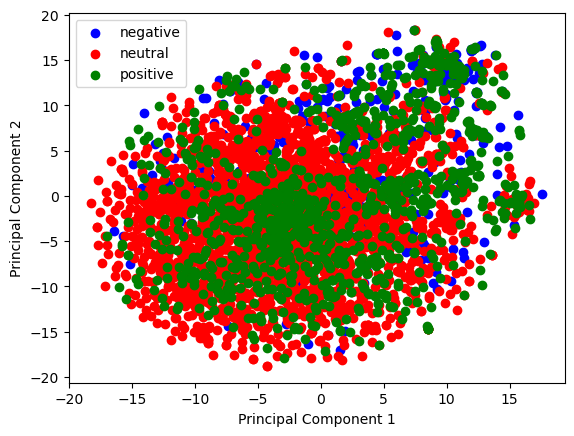

In [12]:
tsne = TSNE(n_components=2, random_state=99)
X_tsne=tsne.fit_transform(X_train)
#X_tsne=tsne.transform(X_train)

plt.scatter(X_tsne[y_train==0, 0], X_tsne[y_train==0, 1], color='blue', label='negative')
plt.scatter(X_tsne[y_train==1, 0], X_tsne[y_train==1, 1], color='red', label='neutral')
plt.scatter(X_tsne[y_train==2, 0], X_tsne[y_train==2, 1], color='green', label='positive')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.show()

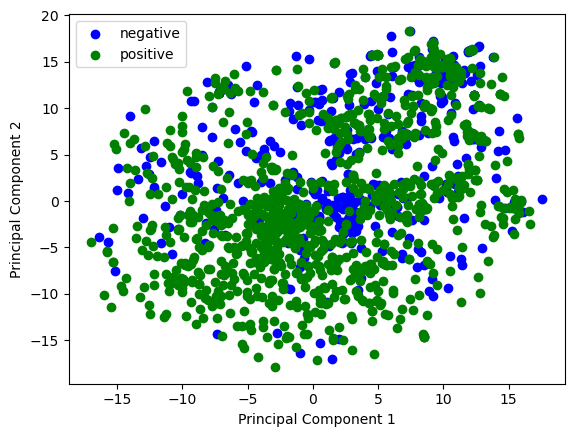

In [13]:
plt.scatter(X_tsne[y_train==0, 0], X_tsne[y_train==0, 1], color='blue', label='negative')
plt.scatter(X_tsne[y_train==2, 0], X_tsne[y_train==2, 1], color='green', label='positive')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.show()

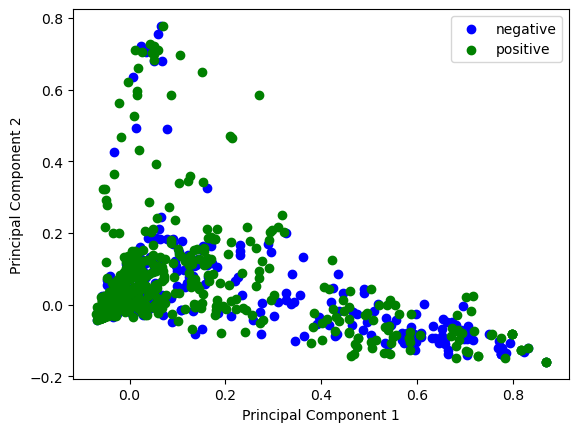

In [14]:
plt.scatter(X_pca[y_train==0, 0], X_pca[y_train==0, 1], color='blue', label='negative')
plt.scatter(X_pca[y_train==2, 0], X_pca[y_train==2, 1], color='green', label='positive')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.show()

## Feature selection using Cross validation

In [15]:
clf= KNeighborsClassifier(100)
vocab_sizes = [2000,1500,1000,500]
cv_scores = []

for vocab_size in vocab_sizes:
    # Filter the dictionary to include only the most frequent vocab_size words
    vocab.filter_extremes(no_below=5,keep_n=vocab_size)
    
    # Convert the training data to bag of words using the filtered dictionary
    doc_bows_trn_filtered = [vocab.doc2bow(doc) for doc in doc_tokens]
    tfidf = TfidfModel(doc_bows_trn_filtered)
    X_tfidf_train = corpus2dense(tfidf[doc_bows_trn_filtered], num_terms=len(vocab), 
                                 num_docs=len(doc_bows_trn_filtered)).transpose()

    # Compute cross-validation accuracy using 5-fold cross-validation
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)
    cv_score = cross_val_score(clf, X_tfidf_train, y_train, cv=strat_k_fold)
    cv_scores.append(cv_score.mean())

# Print the vocabulary size with the highest cross-validation accuracy
best_vocab_size = vocab_sizes[cv_scores.index(max(cv_scores))]
print(f"The best vocabulary size is {best_vocab_size} with a cross-validation accuracy of {max(cv_scores):.2f}")

The best vocabulary size is 1500 with a cross-validation accuracy of 0.66


In [16]:
vocab = Dictionary.from_documents(doc_tokens)
vocab.filter_extremes(no_below=5,keep_n=best_vocab_size)

doc_bows_trn_filtered = [vocab.doc2bow(doc) for doc in doc_tokens]
doc_bows_tst_filtered = [vocab.doc2bow(doc) for doc in test_tokens]

tfidf = TfidfModel(doc_bows_trn_filtered)

X_tfidf_train = corpus2dense(tfidf[doc_bows_trn_filtered], num_terms=len(vocab), num_docs=len(doc_bows_trn_filtered)).transpose()
X_tfidf_test = corpus2dense(tfidf[doc_bows_tst_filtered], num_terms=len(vocab), num_docs=len(doc_bows_tst_filtered)).transpose()

print(X_tfidf_train.shape, X_tfidf_test.shape)

(3876, 1500) (970, 1500)


## Fine tuning pre-trained word2vec and  average word2vec

- using vector size of 250 as it is giving the best accuracy

In [17]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

#loading googlenews pretrained model
model_path = 'GoogleNews-vectors-negative300.bin.gz'
pretrained_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
model = Word2Vec(vector_size=300, min_count=2)
model.build_vocab(doc_tokens)

# Load the pre-trained vectors into the new model and lock them
common_words = [word for word in pretrained_model.key_to_index if word in model.wv.key_to_index]
common_vectors = pretrained_model.vectors[[pretrained_model.key_to_index[word] for word in common_words]]
model.wv.add_vectors(common_words, common_vectors)
model.wv.lockf = 1.0

# Train the model on the corpus
model.train(doc_tokens, total_examples=model.corpus_count, epochs=model.epochs)

(191150, 235605)

In [41]:
print(len(common_words))

3255


In [18]:
W = model.wv
#Train docs with 200 vector size of average w2v
train_vectors = []
for doc in doc_tokens:
    vec = np.zeros((model.vector_size,), dtype=np.float32)
    num_words = 0
    for word in doc:
        if word in W:
            vec += W[word]
            num_words += 1
    if num_words > 0:
        vec /= num_words
    train_vectors.append(vec)
    
#Train docs with 200 vector size of average w2v
test_vectors = []
for doc in X_test:
    vec = np.zeros((model.vector_size,), dtype=np.float32)
    num_words = 0
    for word in doc:
        if word in W:
            vec += W[word]
            num_words += 1
    if num_words > 0:
        vec /= num_words
    test_vectors.append(vec)
print(len(train_vectors),len(test_vectors))

3876 970


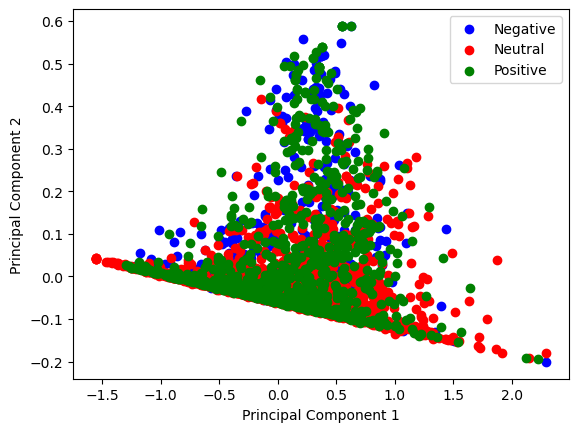

In [19]:
from sklearn.decomposition import PCA

# Perform PCA on train_vectors
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_vectors)

# Create a scatter plot of 2D PCA vectors with color-coded labels
plt.scatter(X_pca[y_train==0, 0], X_pca[y_train==0, 1], color='blue', label='Negative')
plt.scatter(X_pca[y_train==1, 0], X_pca[y_train==1, 1], color='red', label='Neutral')
plt.scatter(X_pca[y_train==2, 0], X_pca[y_train==2, 1], color='green', label='Positive')

# Add labels to the scatter plot
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the scatter plot
plt.show()


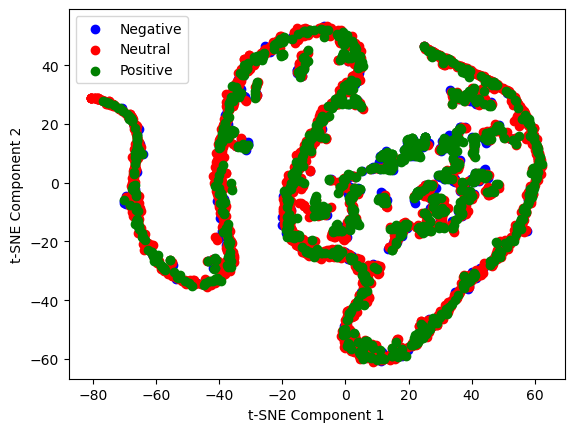

In [20]:
# convert to numpy array
train_numpy = np.array(train_vectors) 

# Perform t-SNE on train_vectors
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(train_numpy)

# Create a scatter plot of 2D t-SNE vectors with color-coded labels
plt.scatter(X_tsne[y_train==0, 0], X_tsne[y_train==0, 1], color='blue', label='Negative')
plt.scatter(X_tsne[y_train==1, 0], X_tsne[y_train==1, 1], color='red', label='Neutral')
plt.scatter(X_tsne[y_train==2, 0], X_tsne[y_train==2, 1], color='green', label='Positive')

# Add labels to the scatter plot
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

# Show the scatter plot
plt.show()

## Max word2vec

In [21]:
def max_pooling_doc2vec(doc):
    word_vecs = [model.wv[word] for word in doc if word in model.wv]
    if word_vecs:
        doc_vec = np.max(word_vecs, axis=0)
    else:
        doc_vec = np.zeros(model.vector_size)
    return doc_vec

pre_train_vectors=[max_pooling_doc2vec(doc) for doc in doc_tokens]
pre_test_vectors=[max_pooling_doc2vec(doc) for doc in test_tokens]

print(len(pre_train_vectors),len(pre_test_vectors))

3876 970


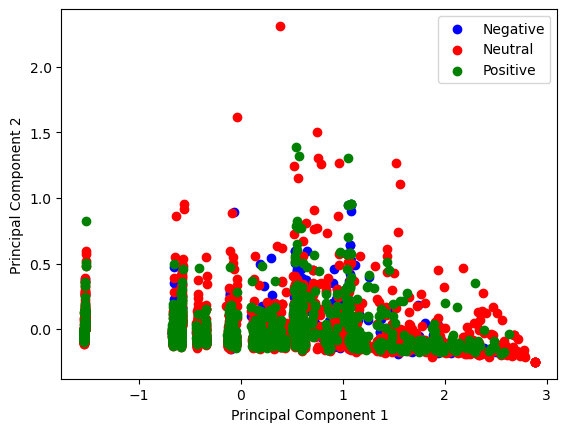

In [22]:
from sklearn.decomposition import PCA

# Perform PCA on train_vectors
pca = PCA(n_components=2)
X_pca = pca.fit_transform(pre_train_vectors)

# Create a scatter plot of 2D PCA vectors with color-coded labels
plt.scatter(X_pca[y_train==0, 0], X_pca[y_train==0, 1], color='blue', label='Negative')
plt.scatter(X_pca[y_train==1, 0], X_pca[y_train==1, 1], color='red', label='Neutral')
plt.scatter(X_pca[y_train==2, 0], X_pca[y_train==2, 1], color='green', label='Positive')

# Add labels to the scatter plot
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the scatter plot
plt.show()


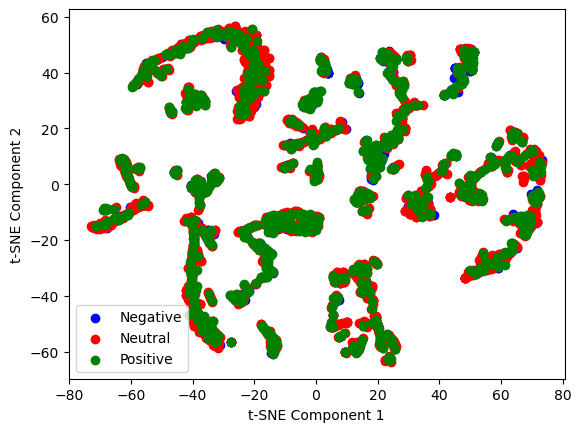

In [23]:
# convert to numpy array
train_numpy = np.array(pre_train_vectors) 

# Perform t-SNE on train_vectors
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(train_numpy)

# Create a scatter plot of 2D t-SNE vectors with color-coded labels
plt.scatter(X_tsne[y_train==0, 0], X_tsne[y_train==0, 1], color='blue', label='Negative')
plt.scatter(X_tsne[y_train==1, 0], X_tsne[y_train==1, 1], color='red', label='Neutral')
plt.scatter(X_tsne[y_train==2, 0], X_tsne[y_train==2, 1], color='green', label='Positive')

# Add labels to the scatter plot
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

# Show the scatter plot
plt.show()


## visualization using doc2vec features

In [24]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# create tagged documents from your list of documents
tagged_docs = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(doc_tokens)]

# train the Doc2Vec model
model = Doc2Vec(tagged_docs, vector_size=300, window=5, min_count=1, workers=4, epochs=10)

In [25]:
train_d2v_vectors = [model.infer_vector(doc) for doc in doc_tokens]
test_d2v_vectors = [model.infer_vector(doc) for doc in test_tokens]

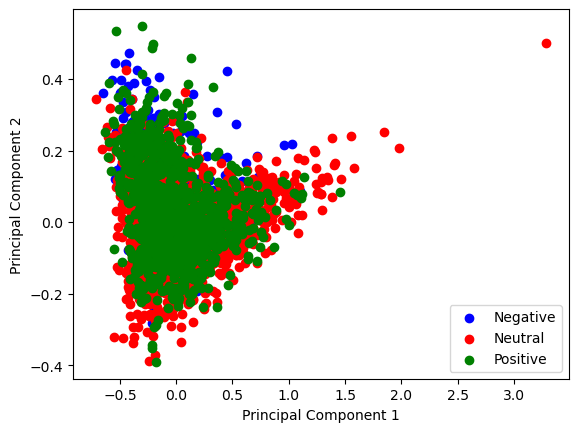

In [26]:
from sklearn.decomposition import PCA

# Perform PCA on train_vectors
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_d2v_vectors)

# Create a scatter plot of 2D PCA vectors with color-coded labels
plt.scatter(X_pca[y_train==0, 0], X_pca[y_train==0, 1], color='blue', label='Negative')
plt.scatter(X_pca[y_train==1, 0], X_pca[y_train==1, 1], color='red', label='Neutral')
plt.scatter(X_pca[y_train==2, 0], X_pca[y_train==2, 1], color='green', label='Positive')

# Add labels to the scatter plot
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the scatter plot
plt.show()

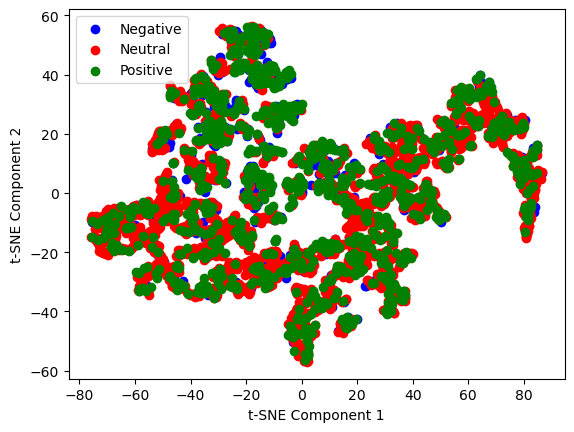

In [27]:
# convert to numpy array
train_numpy = np.array(train_d2v_vectors) 

# Perform t-SNE on train_vectors
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(train_numpy)

# Create a scatter plot of 2D t-SNE vectors with color-coded labels
plt.scatter(X_tsne[y_train==0, 0], X_tsne[y_train==0, 1], color='blue', label='Negative')
plt.scatter(X_tsne[y_train==1, 0], X_tsne[y_train==1, 1], color='red', label='Neutral')
plt.scatter(X_tsne[y_train==2, 0], X_tsne[y_train==2, 1], color='green', label='Positive')

# Add labels to the scatter plot
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

# Show the scatter plot
plt.show()


## Training  and Testing SVM, KNN and random forest on TF-iDF and Averaged W2V for D2V representaion

In [28]:
# Define Random Forest Classifier
rfc = RandomForestClassifier()
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
}

# Perform Grid Search cross-validation to find best hyperparameters
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_tfidf_train, y_train)

# Print best hyperparameters and corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Mean cross-validation score: ", grid_search.best_score_)
# Evaluate performance on test set using best hyperparameters
y_pred = grid_search.predict(X_tfidf_test)
rf_tf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set: ", rf_tf_accuracy)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best hyperparameters:  {'n_estimators': 200}
Mean cross-validation score:  0.7358051213834387
Accuracy on test set:  0.7402061855670103


In [29]:
svm = SVC()
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
}
# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(X_tfidf_train, y_train)
# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Test the model on the test set
y_pred = grid_search.predict(X_tfidf_test)
svm_tf_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", svm_tf_accuracy)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'C': 1, 'kernel': 'linear'}
Best score: 0.7453521782507483
Test accuracy: 0.7371134020618557


In [30]:
knn = KNeighborsClassifier()

# Define parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_tfidf_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
# Predict test set labels
y_pred = grid_search.predict(X_tfidf_test)
# Calculate test accuracy
knn_tf_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", knn_tf_accuracy)

Best parameters: {'n_neighbors': 3}
Best score: 0.6455131360159627
Test accuracy: 0.6391752577319587


In [31]:
# Define Random Forest Classifier
rfc = RandomForestClassifier()
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
}

# Perform Grid Search cross-validation to find best hyperparameters
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(train_vectors, y_train)

# Print best hyperparameters and corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Mean cross-validation score: ", grid_search.best_score_)
# Evaluate performance on test set using best hyperparameters
y_pred = grid_search.predict(test_vectors)
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set: ", rf_accuracy)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best hyperparameters:  {'n_estimators': 500}
Mean cross-validation score:  0.6305463917525773
Accuracy on test set:  0.588659793814433


In [32]:
svm = SVC()
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
}
# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(train_vectors, y_train)
# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Test the model on the test set
y_pred = grid_search.predict(test_vectors)
svm_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", svm_accuracy)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best score: 0.6202254738942468
Test accuracy: 0.588659793814433


In [33]:
knn = KNeighborsClassifier()

# Define parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(train_vectors, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
# Predict test set labels
y_pred = grid_search.predict(test_vectors)
# Calculate test accuracy
knn_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", knn_accuracy)

Best parameters: {'n_neighbors': 11}
Best score: 0.6060385766544729
Test accuracy: 0.588659793814433


In [34]:
# Define Random Forest Classifier
rfc = RandomForestClassifier()
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
}

# Perform Grid Search cross-validation to find best hyperparameters
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(train_d2v_vectors, y_train)

# Print best hyperparameters and corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Mean cross-validation score: ", grid_search.best_score_)
# Evaluate performance on test set using best hyperparameters
y_pred = grid_search.predict(test_d2v_vectors)
rf_d2v_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set: ", rf_d2v_accuracy)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best hyperparameters:  {'n_estimators': 200}
Mean cross-validation score:  0.6233255736614567
Accuracy on test set:  0.6103092783505155


In [35]:
svm = SVC()
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
}
# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(train_d2v_vectors, y_train)
# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Test the model on the test set
y_pred = grid_search.predict(test_d2v_vectors)
svm_d2v_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", svm_d2v_accuracy)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best score: 0.6176491519787163
Test accuracy: 0.6216494845360825


In [36]:
knn = KNeighborsClassifier()

# Define parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(train_d2v_vectors, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
# Predict test set labels
y_pred = grid_search.predict(test_d2v_vectors)
# Calculate test accuracy
knn_d2v_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", knn_d2v_accuracy)

Best parameters: {'n_neighbors': 11}
Best score: 0.6011370136348521
Test accuracy: 0.6051546391752577


In [37]:
# Define Random Forest Classifier
rfc = RandomForestClassifier()
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
}

# Perform Grid Search cross-validation to find best hyperparameters
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(pre_train_vectors, y_train)

# Print best hyperparameters and corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Mean cross-validation score: ", grid_search.best_score_)
# Evaluate performance on test set using best hyperparameters
y_pred = grid_search.predict(pre_test_vectors)
rf_pre_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set: ", rf_pre_accuracy)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best hyperparameters:  {'n_estimators': 500}
Mean cross-validation score:  0.6535071499833721
Accuracy on test set:  0.6587628865979381


In [38]:
svm = SVC()
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
}
# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(pre_train_vectors, y_train)
# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Test the model on the test set
y_pred = grid_search.predict(pre_test_vectors)
svm_pre_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", svm_pre_accuracy)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'C': 10, 'kernel': 'linear'}
Best score: 0.6186774193548387
Test accuracy: 0.6216494845360825


In [39]:
knn = KNeighborsClassifier()

# Define parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(pre_train_vectors, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
# Predict test set labels
y_pred = grid_search.predict(pre_test_vectors)
# Calculate test accuracy
knn_pre_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", knn_pre_accuracy)

Best parameters: {'n_neighbors': 11}
Best score: 0.6093894246757566
Test accuracy: 0.6113402061855671


## conclusion

In [40]:
# Define the data for the table
data = [
    ["TF-IDF", rf_tf_accuracy, knn_tf_accuracy, svm_tf_accuracy],
    ["Pre-trained average Word2Vec", rf_accuracy, knn_accuracy, svm_accuracy],
    ["Doc2Vec", rf_d2v_accuracy, knn_d2v_accuracy, svm_d2v_accuracy],
    ["Pre-trained max Word2Vec", rf_pre_accuracy, knn_pre_accuracy, svm_pre_accuracy]
]

# Define the column headers
headers = ["", "Random Forest", "KNN", "SVM"]

# Print the table
print(tabulate(data, headers=headers))


                                Random Forest       KNN       SVM
----------------------------  ---------------  --------  --------
TF-IDF                               0.740206  0.639175  0.737113
Pre-trained average Word2Vec         0.58866   0.58866   0.58866
Doc2Vec                              0.610309  0.605155  0.621649
Pre-trained max Word2Vec             0.658763  0.61134   0.621649
